Sebastian Raschka (http://sebastianraschka.com, [@rasbt](https://twitter.com/rasbt))  
International Summer School on Deep Learning, Gdansk 2021


GitHub repository: https://github.com/rasbt/2021-issdl-gdansk

---

### Introduction to Generative Adversarial Networks

# 01 -- A Simple GAN Trained on MNIST

## Imports

In [2]:
import os
import random
import time

import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 42
GENERATOR_LEARNING_RATE = 0.0002
DISCRIMINATOR_LEARNING_RATE = 0.0002

NUM_EPOCHS = 20
BATCH_SIZE = 128

IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 28, 28, 1

Device: cpu


In [4]:
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [5]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='.', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


In [6]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


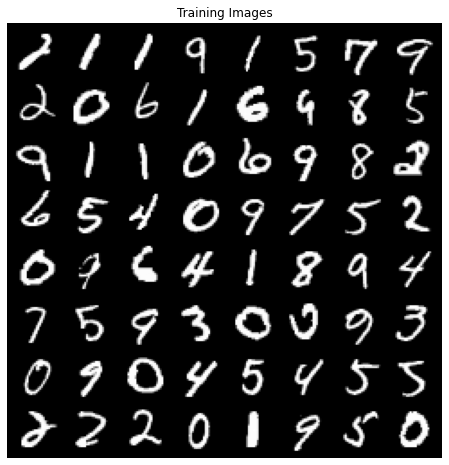

In [7]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))
plt.show()

## Model

In [8]:
##########################
### MODEL
##########################

class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            ##################################################
            ## Exercise 1: ## 
            #################
            ## Which activation function,
            ##   tanh or logistic sigmoid?
            ##   Uncomment the correct one below.
            
            # a) 
            # nn.Sigmoid
            #
            # b) 
            # nn.Tanh
            
            ##################################################
        )
        
        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )
    
    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = model.discriminator(img)
        return logits

In [9]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

## Training

In [10]:
def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr, 
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100, 
                 save_model=None):
    
    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = torch.nn.functional.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            
            ##################################################
            ## Exercise 2: ## 
            #################
            ## Which labels for the real images?
            ## Uncomment the correct code below
            
            # a) 
            # real_labels = torch.zeros(batch_size, device=device)
            #
            # b) 
            # real_labels = torch.ones(batch_size, device=device)
            ##################################################

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            
            ##################################################
            ## Exercise 3: ## 
            #################
            ## Which labels for the generated images?
            ## Uncomment the correct code below
            
            # a) 
            # fake_labels = torch.zeros(batch_size, device=device)
            #
            # b) 
            # fake_labels = torch.ones(batch_size, device=device)
            ##################################################    

            flipped_fake_labels = real_labels

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------   
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
            
            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
            
            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                       % (epoch+1, num_epochs, batch_idx, 
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    
    if save_model is not None:
        torch.save(model.state_dict(), save_model)
    
    return log_dict




log_dict = train_gan_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer_gen=optim_gen,
                        optimizer_discr=optim_discr,
                        latent_dim=100,
                        device=DEVICE, 
                        train_loader=train_loader,
                        logging_interval=100,
                        save_model='gan_mnist_01.pt')

Epoch: 001/100 | Batch 000/469 | Gen/Dis Loss: 0.7359/0.6954
Epoch: 001/100 | Batch 100/469 | Gen/Dis Loss: 0.6071/0.4918
Epoch: 001/100 | Batch 200/469 | Gen/Dis Loss: 0.6474/0.5359
Epoch: 001/100 | Batch 300/469 | Gen/Dis Loss: 0.7101/0.5577
Epoch: 001/100 | Batch 400/469 | Gen/Dis Loss: 0.8886/0.4648
Time elapsed: 0.09 min
Epoch: 002/100 | Batch 000/469 | Gen/Dis Loss: 1.0553/0.3862
Epoch: 002/100 | Batch 100/469 | Gen/Dis Loss: 1.0539/0.4043
Epoch: 002/100 | Batch 200/469 | Gen/Dis Loss: 0.9426/0.4306
Epoch: 002/100 | Batch 300/469 | Gen/Dis Loss: 1.0976/0.4106
Epoch: 002/100 | Batch 400/469 | Gen/Dis Loss: 1.0924/0.4252
Time elapsed: 0.18 min
Epoch: 003/100 | Batch 000/469 | Gen/Dis Loss: 1.1323/0.4080
Epoch: 003/100 | Batch 100/469 | Gen/Dis Loss: 1.0478/0.4261
Epoch: 003/100 | Batch 200/469 | Gen/Dis Loss: 1.0200/0.4445
Epoch: 003/100 | Batch 300/469 | Gen/Dis Loss: 1.0663/0.4609
Epoch: 003/100 | Batch 400/469 | Gen/Dis Loss: 1.1606/0.4350
Time elapsed: 0.27 min
Epoch: 004/100 |

## Evaluation

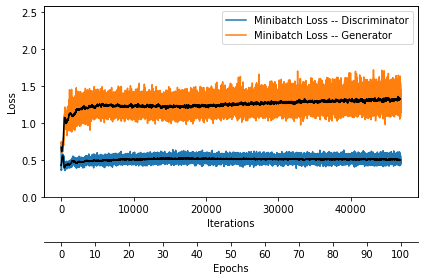

In [11]:
def plot_multiple_training_losses(losses_list, num_epochs,
                                  averaging_iterations=100, custom_labels_list=None):

    for i, _ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i, _ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()



plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCHS, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

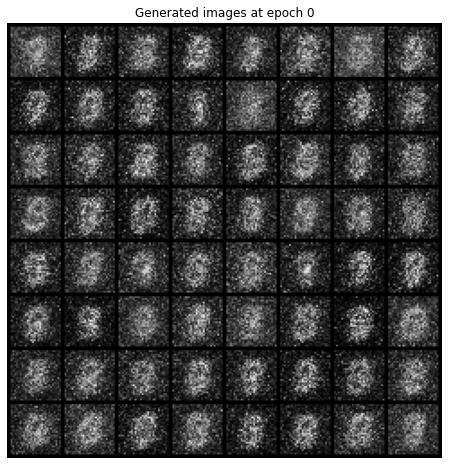

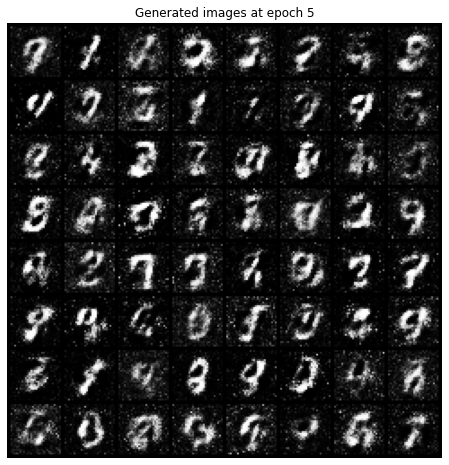

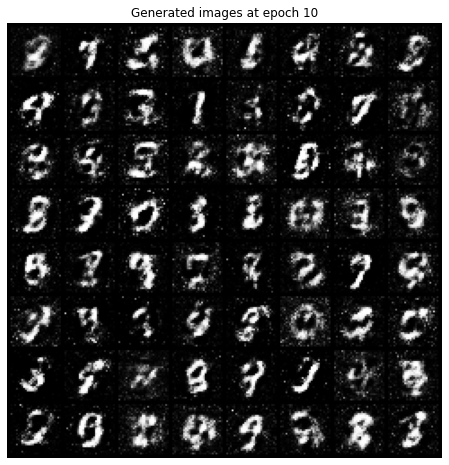

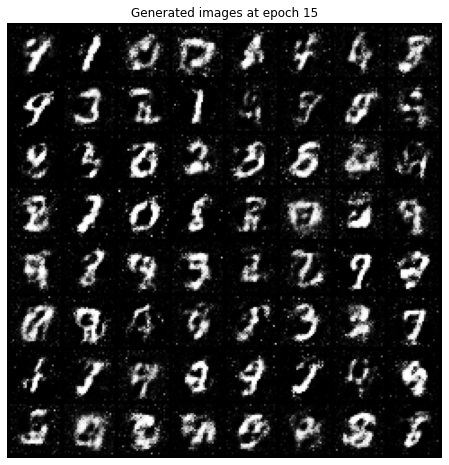

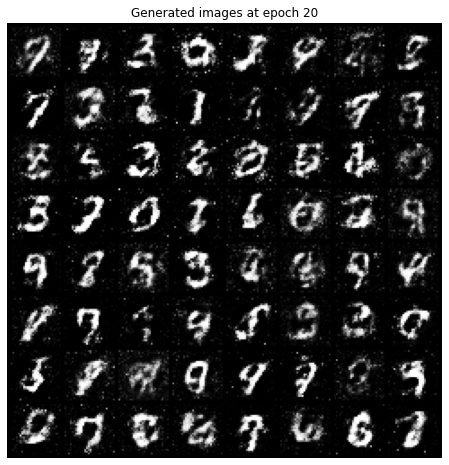

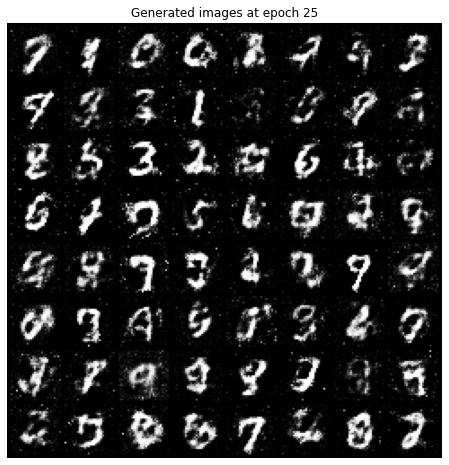

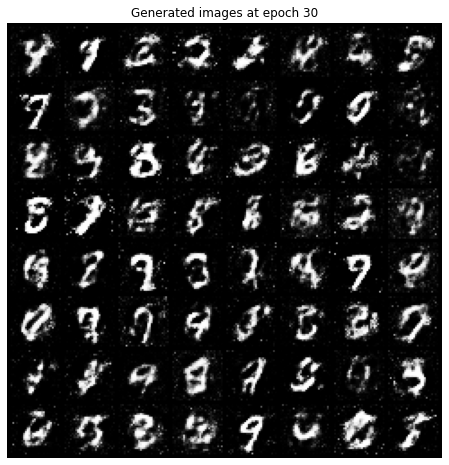

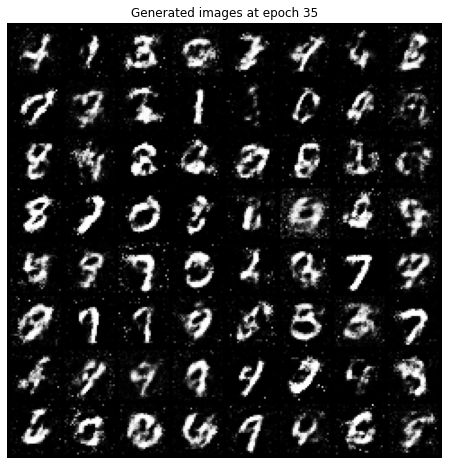

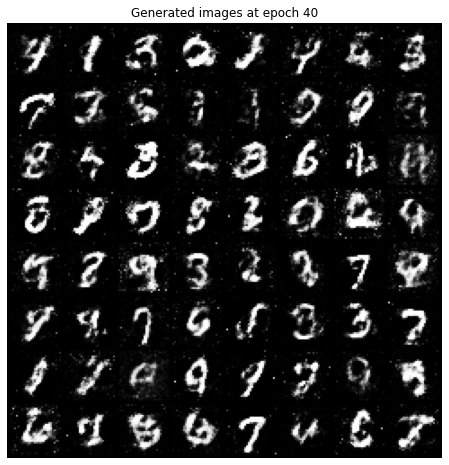

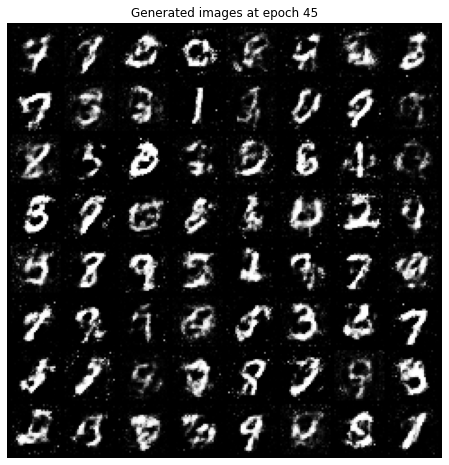

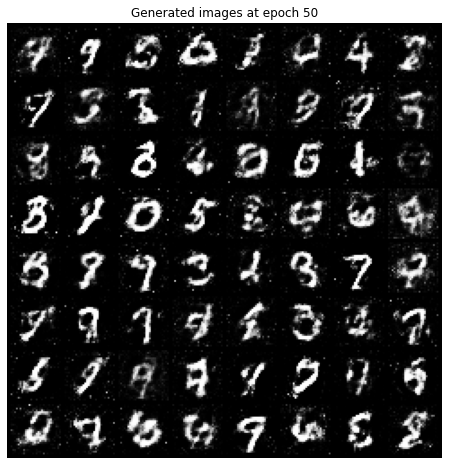

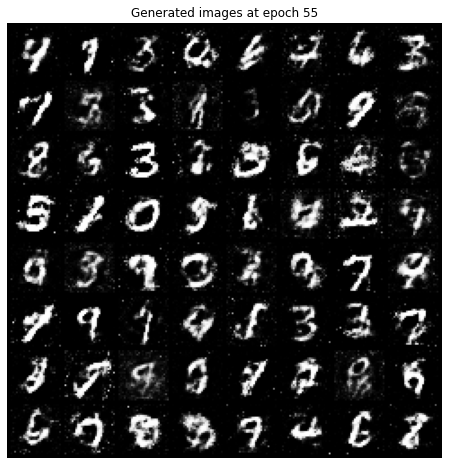

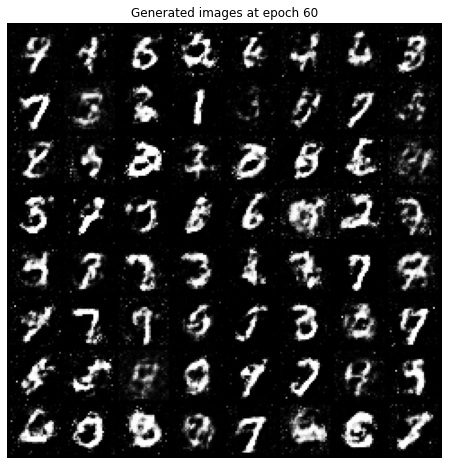

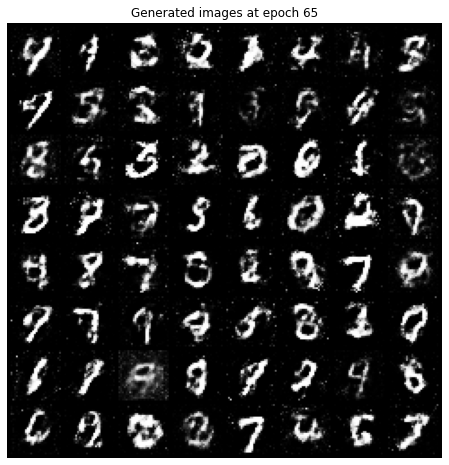

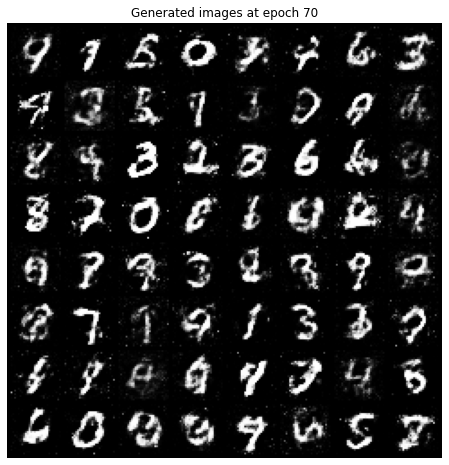

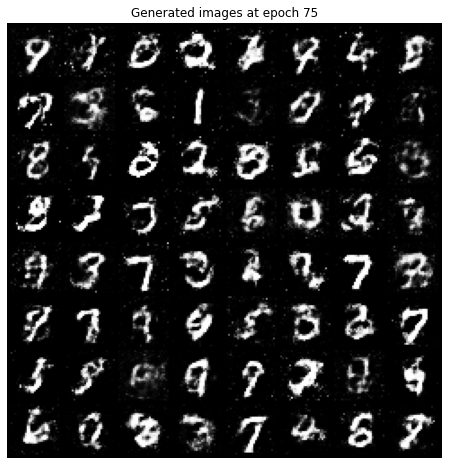

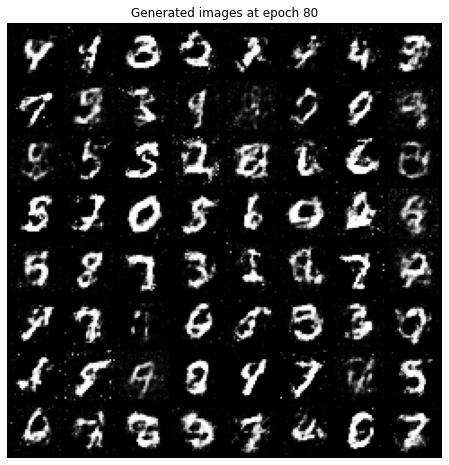

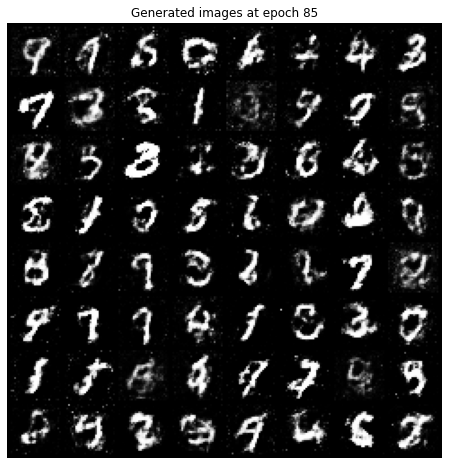

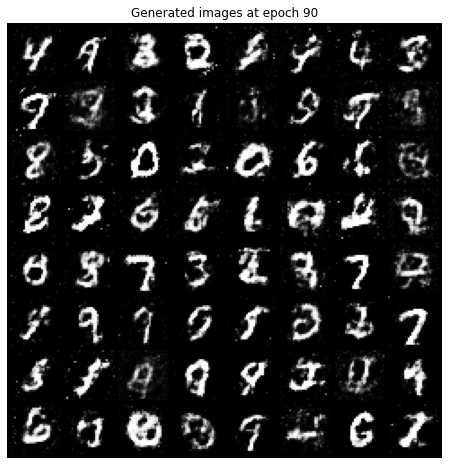

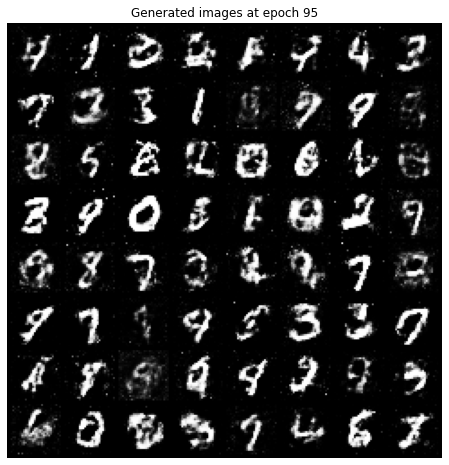

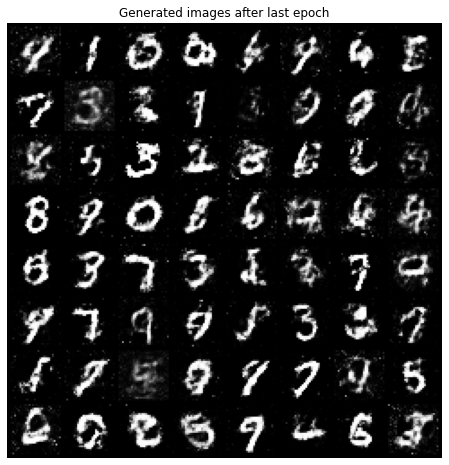

In [12]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()
    
    
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()